Number of rows with empty title: 1
Original shape: (80392, 6)
Out of the original 80391 samples: I will be using 25824 for training, 6439 for validation, and 7941 for testing.


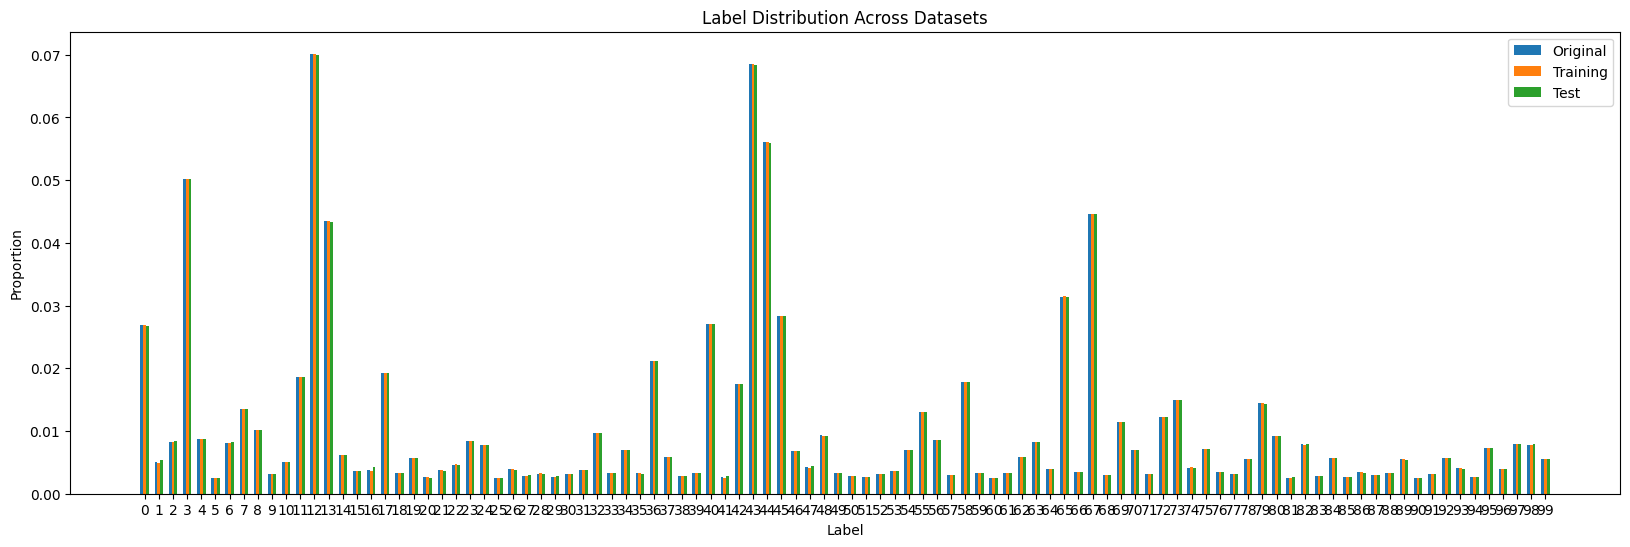

In [2]:
import os
import pickle
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multiclass import OneVsRestClassifier
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.metrics import hamming_loss, jaccard_score, classification_report

# pip install xgboost

project_dir = os.getcwd()

df = pd.read_pickle(f"{project_dir}\\main_df_after_sanitization.pkl")

# Drop row where title == ''
print(f'Number of rows with empty title: {df[df["Title"] == ""].shape[0]}')
print(f'Original shape: {df.shape}')
df = df[df['Title'] != '']

# If title does not end in punctuation, add a period
df['Title'] = df['Title'].apply(lambda x: x if x[-1] in ['.', '!', '?'] else x + '.')
df['input'] = df.Title + ' ' + df.Body

# Train test split first

X = df['input'].values

# Transform tags into a binary format suitable for multi-label classification
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['Tag'])

#https://github.com/scikit-multilearn/scikit-multilearn/issues/147#issuecomment-519713267
np.random.seed(0) 

# We are now going to split the dataset in order to reduce it but at the same time keep the distribution of the labels as close as possible to the original dataset.

# Step 1: Reduce the size of the dataset by half while maintaining label distribution
X_part, y_part, X_unused, y_unused = iterative_train_test_split(X.reshape(-1, 1), y, test_size=0.5)

# Step 2: Split the reduced dataset into train and test sets
X_train, y_train, X_test, y_test = iterative_train_test_split(X_part, y_part, test_size=0.2)

# Step 3: Create a validation set from the training set
X_train, y_train, X_val, y_val = iterative_train_test_split(X_train, y_train, test_size=0.2)

print(f'Out of the original {X.shape[0]} samples: I will be using {X_train.shape[0]} for training, {X_val.shape[0]} for validation, and {X_test.shape[0]} for testing.')

# Summing up the occurrences of each label
original_label_counts = np.sum(y, axis=0)
training_label_counts = np.sum(y_train, axis=0)
test_label_counts = np.sum(y_test, axis=0)

# calculating proportions
original_label_proportions = original_label_counts / np.sum(original_label_counts)
training_label_proportions = training_label_counts / np.sum(training_label_counts)
test_label_proportions = test_label_counts / np.sum(test_label_counts)

# Assuming you have the same number of labels in each dataset
labels = np.arange(y.shape[1])  # Convert range to numpy array for element-wise operations

plt.figure(figsize=(20, 6))
plt.bar(labels - 0.2, original_label_proportions, width=0.2, label='Original', align='center')
plt.bar(labels, training_label_proportions, width=0.2, label='Training', align='center')
plt.bar(labels + 0.2, test_label_proportions, width=0.2, label='Test', align='center')
plt.xlabel('Label')
plt.ylabel('Proportion')
plt.title('Label Distribution Across Datasets')
plt.legend()
plt.xticks(labels, labels)  # Adjust tick positions and labels if necessary
plt.show()

# diff_training = np.abs(original_label_proportions - training_label_proportions)
# diff_test = np.abs(original_label_proportions - test_label_proportions)

# # Print or inspect these differences
# print("Difference between original and training distributions:", diff_training)
# print("Difference between original and test distributions:", diff_test)

In [3]:
# Initialize TfidfVectorizer with the specified parameters

vectorizer = TfidfVectorizer(analyzer='word',
                             min_df=0.0, # ignore no terms
                             max_df=1.0, 
                             strip_accents=None,
                             encoding='utf-8',
                             preprocessor=None,
                             token_pattern=r"(?u)\S\S+",
                             max_features=5000,
                             stop_words='english',
                            )

# Fit and transform the training data
X_train_flat = [x[0] for x in X_train]  # Flatten the training data
X_train_tfidf = vectorizer.fit_transform(X_train_flat)

# You would also transform your validation set here (which you've split previously)
X_val_flat = [x[0] for x in X_val]  # Flatten the validation data
X_val_tfidf = vectorizer.transform(X_val_flat)

X_test_flat = [x[0] for x in X_test]  # Flatten the test data
X_test_tfidf = vectorizer.transform(X_test_flat)

In [8]:
# Get feature names
feature_names = vectorizer.get_feature_names()

# Sum tfidf frequency of each term through documents
sums = X_train_tfidf.sum(axis=0)  # Sum tfidf values for each term in the corpus

# Connecting term to its sums frequency
data = []
for col, term in enumerate(feature_names):
    data.append((term, sums[0,col]))

ranking = sorted(data, key=lambda x: x[1], reverse=True)
ranking[:10]

[('-pron-', 3778.844839271165),
 ('use', 842.8668759969831),
 ('file', 596.1117330567132),
 ('like', 499.4755162061013),
 ('class', 492.565790638181),
 ('code', 482.8265120825919),
 ('function', 468.58753572891544),
 ('return', 445.71874750895955),
 ('work', 445.6748449646443),
 ('string', 440.62520247461316)]

In [10]:
param_grid = {
    'estimator__max_depth': [3, 10],
    'estimator__learning_rate': [0.01, 0.3],
    'estimator__n_estimators': [100, 300],
    'estimator__colsample_bytree': [0.3, 1.0],
    # Add other parameters you want to tune
}

# # # create small parameter grid for testing
# param_grid = {
#     'estimator__max_depth': [3],
# }

# Define scoring for multi-label classification
scoring = 'f1_micro'

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(
                                    objective='binary:logistic',
                                    eval_metric='logloss', 
                                    use_label_encoder=False,
                                    max_depth=5,
                                    eta=0.2,
                                    gamma=4,
                                    min_child_weight=6,
                                    subsample=0.8,
                                   )

# Use OneVsRestClassifier for multi-label problem
clf = OneVsRestClassifier(xgb_classifier)

# Initialize RandomizedSearchCV
search = RandomizedSearchCV(
    clf,
    param_distributions=param_grid,
    n_iter=2,
    scoring=scoring,
    cv=2,
    verbose=1,
    random_state=42
)

# Perform the search on the training data
search.fit(X_train_tfidf, y_train)

# Best model
best_clf = search.best_estimator_

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [34]:
# Predict on the test data
best_predictions = best_clf.predict(X_test_tfidf)

# Evaluate the predictions using an appropriate metric, such as the F1 score

f1 = f1_score(y_test, best_predictions, average='micro')  # Ensure y_test is in the correct binary format
print(f"Test Set F1 Score: {f1:.2f}")

# Hamming Loss: The fraction of the wrong labels to the total number of labels. It's a loss function, so the optimal value is zero. / Not great for sparse data
# Jaccard Score: Also known as the Jaccard similarity coefficient, which measures the average overlap between the predicted and actual label sets.

# Exact Match Ratio: Most strict metric, indicating the percentage of samples that have all their labels classified correctly. 
# Classification Report: Provides a breakdown of precision, recall, and F1-score for each class.

# Hamming Loss of 0.01 suggests that only 1% of the label predictions are incorrect. 
# However, this metric can sometimes be misleading, especially if you have a dataset with a large number of labels but sparse label assignments (many zeroes in your label matrix). 
# In such cases, a model that predicts no labels (all zeroes) could still have a low Hamming Loss, but it wouldn't be a useful model. Which is the case here.

# Jaccard Similarity Score: This metric is the size of the intersection of the predicted labels and the true labels divided by the size of the union of the predicted and true labels.
# It is a good indicator of accuracy for multi-label classification.

ham_loss = hamming_loss(y_test, best_predictions)
jaccard = jaccard_score(y_test, best_predictions, average='samples')  # 'samples' for instance-wise averaging

# Print the metrics
print(f"Hamming Loss: {ham_loss:.2f}")
print(f"Jaccard Score: {jaccard:.2f}")

# Print classification report
print(classification_report(y_test, best_predictions))


Test Set F1 Score: 0.03
Hamming Loss: 0.02
Jaccard Score: 0.01
              precision    recall  f1-score   support

           0       0.33      0.03      0.05        34
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         1
           6       0.25      0.07      0.11        15
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00        10
          11       0.15      0.12      0.13        49
          12       0.25      0.05      0.08        21
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         3
          16      

c:\Users\Nick\anaconda3\envs\C4P\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nick\anaconda3\envs\C4P\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nick\anaconda3\envs\C4P\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
# To work on the same datasets for the LLM approach as well
train_df = pd.DataFrame(X_train, columns=['input'])
train_df['Tag'] = y_train.tolist()
train_df.to_pickle('train_df.pkl')

val_df = pd.DataFrame(X_val, columns=['input'])
val_df['Tag'] = y_val.tolist()
val_df.to_pickle('val_df.pkl')

test_df = pd.DataFrame(X_test, columns=['input'])
test_df['Tag'] = y_test.tolist()
test_df.to_pickle('test_df.pkl')
